In [1]:
import tensorflow as tf
import numpy as np
import pandas as pd
import ast
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, KFold
from tensorflow.keras.preprocessing.sequence import pad_sequences
import seaborn as sns
#from google.colab import drive
#from keras.models import model_from_yaml
import numpy
import os
#drive.mount('/content/drive')

In [2]:
#df = pd.read_csv('drive/My Drive/Tesis/Data/Flujo1.csv', sep=";")
df = pd.read_csv('../Data/Flujo1.csv', sep=";")
df['Respuesta'] = df['Respuesta'].apply(ast.literal_eval)
def enumerate_dimensions(dimension, list_dimensions):
    return list_dimensions.index(dimension)

def wordsToNumbers(tokens, vocabulary):
    number_array = []
    for i in tokens:
        number_array.append(vocabulary.index(i)+1)
    return np.asarray(number_array)

## Modelo

In [3]:
# Se Construye Dataframe solo de medio ambiente
df = df[df.Area == 'Gobierno Corporativo']
# Lista de dimensiones se pasa a numeros
list_dimensions = df.Dimension.unique().tolist()
num_classes = len(list_dimensions)
df['_dimension'] = df['Dimension'].apply(enumerate_dimensions, list_dimensions = list_dimensions)
#Generamos un vocabulario de palabras
vocabulary = []
df['Respuesta'].apply(vocabulary.append)
vocabulary = [item for sublist in vocabulary for item in sublist]
vocabulary = list(set(vocabulary))
resultados = []

In [4]:
vocabulary_to_save = pd.DataFrame(vocabulary, columns = ['words'])
vocabulary_to_save.to_csv(r'../Data/vocabulary.csv', index=False)

In [5]:
df['NumRespuesta'] = df.Respuesta.apply (wordsToNumbers, vocabulary = vocabulary)
# Rellenamos las matrices con 0 para que todas tengan el mismo tamaño
X_completo = pad_sequences(df.NumRespuesta, maxlen=10, dtype='object', padding='post', value = 0)
# Pasamos las dimensiones a np array
y_completo = np.array(df['_dimension'])
X, test_x, y, test_y = train_test_split(X_completo, y_completo, test_size = 0.2, random_state = 0)

In [0]:
#Prueba celda prueba

vocab_len= len(vocabulary)+1
num_classes = len(list_dimensions)
ouput_dim_embedding = 50
lstm_units = 110
ouputs_dense = 2
epoch = 6
batch_size = 60
optimizer = 'rmsprop'

model = tf.keras.Sequential()
#Se agrega capa embedding que hace w2v
model.add(tf.keras.layers.Embedding(input_dim=vocab_len, output_dim = ouput_dim_embedding, input_shape=(X.shape[1],)))
model.add(tf.keras.layers.LSTM(units = lstm_units, activation='sigmoid', dropout=0.7, recurrent_dropout=0.7))
model.add(tf.keras.layers.Dense(units = ouputs_dense, activation='sigmoid'))
model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['sparse_categorical_accuracy'])
#model.summary()
history = model.fit(X, y, epochs = epoch, batch_size = batch_size)
print()
print('-Resultados con datos de testeo ')
print()
test_loss, test_acurracy = model.evaluate(test_x, test_y) 
print()
print('-Data Test accuracy: {}'.format(test_acurracy))
resultados.append(test_acurracy)
print()
predictions = model.predict_classes(test_x)
#Matriz de confusion
confusion = tf.confusion_matrix(labels=test_y, predictions= predictions, dtype=tf.dtypes.int32, num_classes=2)
print('-Matriz de confusion')
print(confusion.eval(session=tf.Session()))
print()
resultados

Train on 11438 samples
Epoch 1/6
11438/11438 [==============================] - 8s 680us/sample - loss: 0.6940 - sparse_categorical_accuracy: 0.5169
Epoch 2/6
11438/11438 [==============================] - 6s 515us/sample - loss: 0.6408 - sparse_categorical_accuracy: 0.6275
Epoch 3/6
11438/11438 [==============================] - 6s 515us/sample - loss: 0.4850 - sparse_categorical_accuracy: 0.7681
Epoch 4/6
11438/11438 [==============================] - 6s 505us/sample - loss: 0.4426 - sparse_categorical_accuracy: 0.7925
Epoch 5/6
11438/11438 [==============================] - 6s 511us/sample - loss: 0.4183 - sparse_categorical_accuracy: 0.8090
Epoch 6/6
11438/11438 [==============================] - 6s 509us/sample - loss: 0.4003 - sparse_categorical_accuracy: 0.8205

-Resultados con datos de testeo 

2860/2860 [==============================] - 2s 863us/sample - loss: 0.4750 - sparse_categorical_accuracy: 0.7860

-Data Test accuracy: 0.7860139608383179

-Matriz de confusion
[[1138  2

In [5]:
vocab_len= len(vocabulary)+1
num_classes = len(list_dimensions)
ouput_dim_embedding = 50
lstm_units = 110
ouputs_dense = 2
epoch = 6
batch_size = 60
optimizer = 'rmsprop'

kf = KFold(n_splits = 8, shuffle = True, random_state = 2)
resultados = []
contador = 1
for valores_entrenamiento, valores_testeo in kf.split(X):
    model = tf.keras.Sequential()
    #Se agrega capa embedding que hace w2v
    model.add(tf.keras.layers.Embedding(input_dim=vocab_len, output_dim = ouput_dim_embedding, input_shape=(X.shape[1],)))
    model.add(tf.keras.layers.LSTM(units = lstm_units, activation='sigmoid', dropout=0.7, recurrent_dropout=0.7))
    model.add(tf.keras.layers.Dense(units=ouputs_dense, activation='sigmoid'))
    model.compile(optimizer='rmsprop', loss='sparse_categorical_crossentropy', metrics=['sparse_categorical_accuracy'])
    #model.summary()
    history = model.fit(X[valores_entrenamiento], y[valores_entrenamiento], epochs = epoch, batch_size = batch_size)
    print()
    print(contador, '-Resultados con datos de testeo ')
    print()
    test_loss, test_acurracy = model.evaluate(X[valores_testeo], y[valores_testeo])
    print()
    print(contador, '-Data Test accuracy: {}'.format(test_acurracy))
    resultados.append(test_acurracy)
    print()
    predictions = model.predict_classes(X[valores_testeo])
    #Matriz de confusion
    confusion = tf.confusion_matrix(labels=y[valores_testeo], predictions= predictions, dtype=tf.dtypes.int32, num_classes=num_classes)
    print(contador, '-Matriz de confusion')
    print(confusion.eval(session=tf.Session()))
    print()
    contador = contador + 1

print(resultados)
print(np.array(resultados).mean())

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
If using Keras pass *_constraint arguments to layers.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Train on 10008 samples
Epoch 1/6
10008/10008 [==============================] - 5s 544us/sample - loss: 0.6942 - sparse_categorical_accuracy: 0.5136
Epoch 2/6
10008/10008 [==============================] - 3s 322us/sample - loss: 0.6680 - sparse_categorical_accuracy: 0.5845
Epoch 3/6
10008/10008 [==============================] - 3s 341us/sample - loss: 0.5214 - sparse_categorical_accuracy: 0.7415
Epoch 4/6
10008/10008 [==============================] - 3s 329us/sample - loss: 0.4532 - sparse_categorical_accuracy: 0.7869
Epoch 5/6
10008/10008 [==============================] - 3s 336us/sample - loss: 0.4271 - sparse_categorical_accuracy: 0.7999
Epoch 6/6
10008/10008 [==============================]

In [9]:
model_yaml = model.to_yaml()
with open("drive/My Drive/Tesis/RNN/GOB/modelGOB.yaml", "w") as yaml_file:
    yaml_file.write(model_yaml)
# serialize weights to HDF5
model.save_weights("drive/My Drive/Tesis/RNN/GOB/modelGOB.h5")
print("Saved model to disk")

Saved model to disk


In [0]:
for i in range(len(predictions)):
    print('Para texto:', [vocabulary[item] for item in X[valores_testeo][i]])
    print('El valor Predicho es', predictions[i], 'Y deberia ser', y[valores_testeo][i])

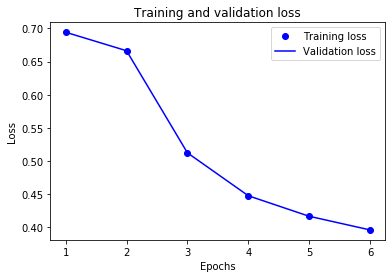

In [0]:
import matplotlib.pyplot as plt
history_dict = history.history
acc = history_dict['sparse_categorical_accuracy']
loss = history_dict['loss']

epochs = range(1, len(acc) + 1)

# "bo" is for "blue dot"
plt.plot(epochs, loss, 'bo', label='Training loss')
# b is for "solid blue line"
plt.plot(epochs, loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

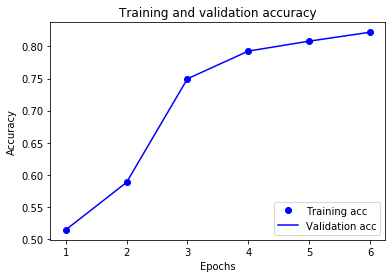

In [0]:
plt.clf()   # clear figure

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')

plt.show()

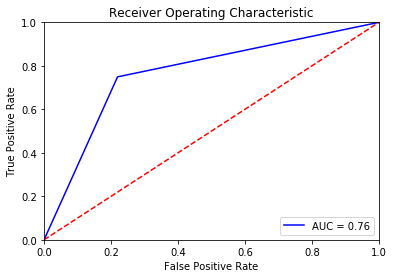

In [0]:
import sklearn.metrics as metrics

fpr, tpr, threshold = metrics.roc_curve(y[valores], predictions)
roc_auc = metrics.auc(fpr, tpr)

import matplotlib.pyplot as plt
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()